# SSM


## States
Let $\bar r_t = \log \bar \rho_t$ be the average growth factor (on the log scale) across all counties and $u_t^c$ be the deviation of county $c$'s log-growth factor for $\bar r_t$. 
We model $\bar r_t$ following a random walk and $u^\cdot_t$ following an $\text{VAR}(1)$ process with transition matrix $\alpha I$ and spatial correlation $\Omega$.

Thus we have
$$
\begin{align*}
\bar r_{t + 1} &= \bar r_{t} + \varepsilon_{t + 1}^\rho \\
u^c_{t + 1} &= \alpha u^c_t + \varepsilon_{t + 1}^c
\end{align*}
$$

with $\text{Var}(\varepsilon_{t + 1}^\rho) = \sigma^2_\rho$ and $\text{Cov}(\varepsilon_{t + 1}) = \Omega$. 
The covariance matrix of the stationary distribution is $\Sigma = \frac {1} {1 - \alpha^2} \Omega$.

## Observations
The log growth factor in a region at time $t$, $r^c_t$, is given by the mean log growth factor $\bar r_t$ and the per-region deviation $u^c_t$.
Conditional on the log growth factors and past cases, cases are Negative Binomially distributed with shared overdispersion parameter $r$
$$
\begin{align*}
r^c_t &= \bar r_t + u^c_{t} \\
\lambda_t^c &= \exp(r^c_t) \sum_{d}p_{c,d} I_t^d \\
I^c_{t + 1} | I^c_{t}, \rho_t, u^c_t &\sim \text{NegBinom}(\underbrace{\lambda_t^c}_{\text{mean}}, \underbrace{r}_{\text{overdispersion}})
\end{align*}
$$

where the variance of the negative binomial distribution is $\mu + \frac{\mu^2}{r}$


## Spatial Correlations

Suppose we have in county $c$ $S^c$ many new infections generated, which may be attributed to the same county or another one, $c'$ say.
Let $p_{c,c'}$ be the fraction of cases generated in county $c'$ (instead of in county $c$) and $p_{c,c} = 1 - \sum_{c' \neq c} p_{c,c'}$.


Let $P = \left(p_{c,c'}\right)_{c = 1, \dots, K, c' = 1,\dots, K}$.

Let $\tilde S^c = \sum p_{c,d} S^d$ be the number of cases generated in county $c$.

Then we are interested in 

$$
\begin{align*}
    \text{Cov}(\tilde S^c, \tilde S^{c'}) = \underbrace{\sigma^2}_{\text{Var}(S^c)} (\sum_{d} p_{c,d} p_{c',d}) = \sigma^2_{\text{spat}} (P P^T)_{c, c'}
\end{align*}
$$


To obtain $p_{c,c'}$ we use data on commuters $q_{c,c'}$ the fraction of socially insured employees that have their center of life in county $c$ but are registered to work in county $c'$. 

To account for non-working inhabitants (elderly, kids, ...) we introduce a constant $C \geq 1$ s.t. 
$$
p_{c,c'} = \bar q + (1 - \bar q)\frac{\mathbf 1 _{c \neq c'} q_{c,c'}}{ \sum_{d \neq c} q_{c,d} + C q_{c,c}},
$$
i.e. we blow up the proportion of "stay at home" by a constant $C$ (that is the same for all counties) and add a constant "socket" of travel $\bar q$ between the counties.


Finally we choose

$$
\Omega = \sigma^2_{\text{spat}}PP^T %+ \sigma^2_{\text{nugget}} I
$$


## Parameters

$$
\theta = \left( \text{logit}(\alpha), \log \sigma^2_r, \log \sigma^2_{\text{spat}}, C, \log \mu \right)%\log \sigma^2_{\text{nugget}}, \log \mu \right)
$$



# Data

In [1]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax.config as config
import matplotlib as mpl

In [2]:
mpl.rcParams["figure.figsize"] = (20, 6)

config.update("jax_enable_x64", True)
# for debugging purposes
#config.update('jax_platform_name', 'cpu')
#config.update("jax_debug_nans", True)
#config.update('jax_disable_jit', True)

In [6]:
rki = pd.read_csv("../data/processed/RKI_county_weekly.csv", encoding = "unicode-escape", dtype = {'ags': str})
rki['date'] = pd.to_datetime(rki['date'])

dtypes = {'ags_work': str, 'ags_home': str}
outcommuters = pd.read_csv("../data/processed/outcommuters.csv", dtype=dtypes)
home_total = pd.read_csv("../data/processed/home_totals.csv", dtype={'ags': str})

ags_state_dict = pd.read_csv("../data/processed/ags_state_dict.csv", dtype={'ags': str, 'state': str})
ags_county_dict = pd.read_csv("../data/processed/ags_county_dict.csv", dtype={'county': str, 'ags': str})

joint_ags = np.intersect1d(outcommuters["ags_work"].values, rki['ags'].values)
#joint_ags = joint_ags[np.where([ags.startswith('16') for ags in joint_ags])]
# all ags that start with 11 - 16
# whole east germany
joint_ags = joint_ags[np.where([ags.startswith('16') or ags.startswith('15') or ags.startswith('14') for ags in joint_ags])]

rki = rki[rki["ags"].isin(joint_ags)]


considered_indices = jnp.arange(9, 19) + 20 
# indices from the end of considered_indices to the end of the data
considered_indices_to_predict = jnp.arange(1, 5) + max(considered_indices)
rki_pivot = rki.pivot(index='date', columns='ags', values='cases').iloc[considered_indices]
rki_to_predict = rki.pivot(index='date', columns='ags', values='cases').iloc[considered_indices_to_predict]

lagged_observations = jnp.array(rki_pivot.to_numpy())[:-1]
observations = jnp.array(rki_pivot.to_numpy())[1:]
observations_to_predict = jnp.array(rki_to_predict.to_numpy())

ags = rki_pivot.columns
dates = rki_pivot.index[1:]

state = np.array([
    ags[:2] for ags in joint_ags
])

state_lims = np.cumsum(np.unique(state, return_counts=True)[1])

In [7]:
if lagged_observations[0].sum() == 0:
    raise ValueError("Cannot start with 0 past incidences")
print(f"from {dates[0]} to {dates[-1]}")
#counties = ags_county_dict.query('ags.str.startswith("16")').query('ags.isin(@joint_ags)').name.to_numpy()
counties = ags_county_dict.query('ags.isin(@joint_ags)').name.to_numpy()

from 2020-07-27 00:00:00 to 2020-09-21 00:00:00


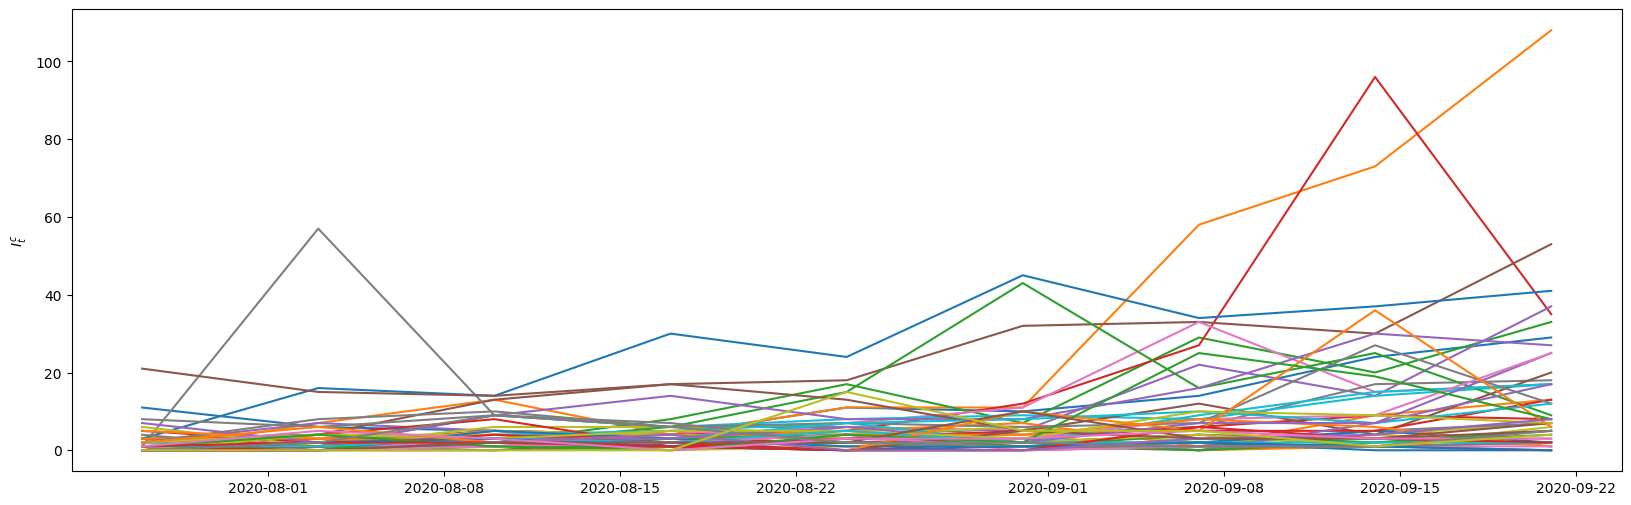

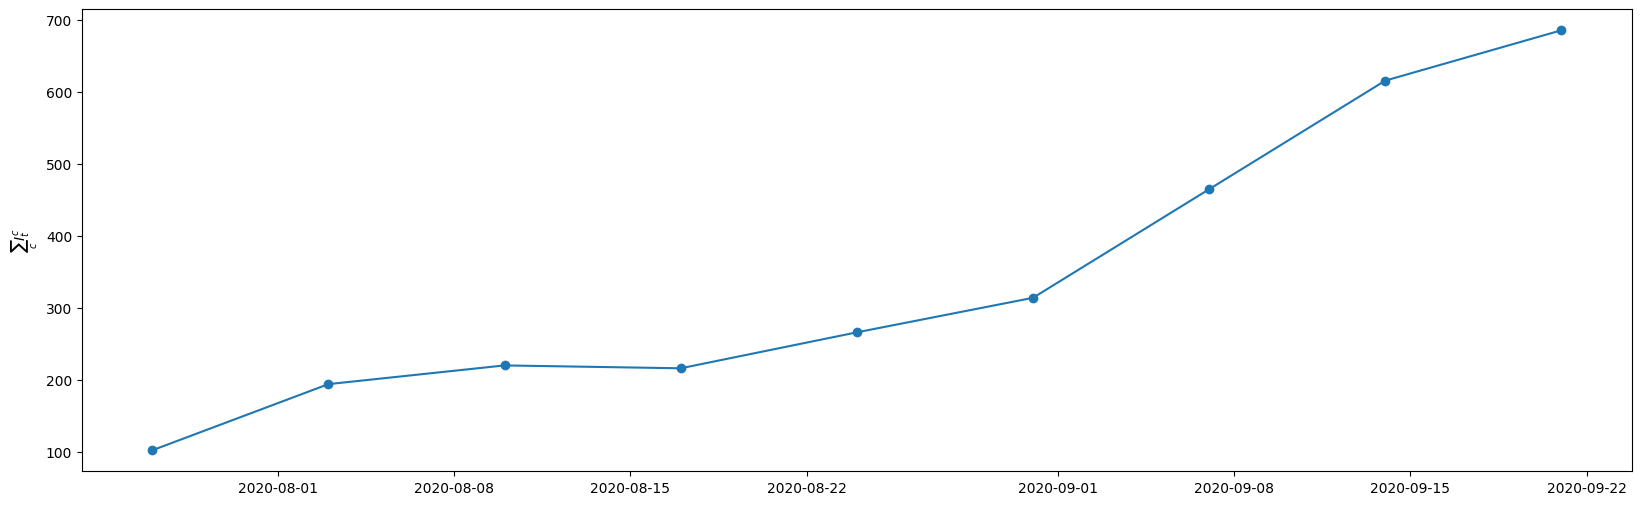

In [8]:
for i in jnp.arange(observations.shape[1]):
    obs = observations[:,i]
    county = counties[i]
    plt.plot(dates, obs, label = county)
plt.ylabel("$I_t^c$")
plt.show()

plt.plot(dates, observations.sum(axis=1))
plt.scatter(dates, observations.sum(axis=1))
plt.ylabel("$\sum_c I_t^c$")
plt.show()

In [10]:
outcommuters_joint = outcommuters[outcommuters["ags_home"].isin(joint_ags) * outcommuters["ags_work"].isin(joint_ags)]
home_total_joint = home_total[home_total["ags"].isin(joint_ags)]

n_ij = jnp.array(outcommuters_joint.pivot(index="ags_home", columns="ags_work", values="total").to_numpy())
n_tot = jnp.array(home_total_joint.total.to_numpy())

# Parameters

In [37]:
n, p = observations.shape
m = p + 1
r = m

def logit(x, low = 0, high = 1):
    p = (x - low) / (high - low)
    return jnp.log(p / (1 - p))

def expit(x, low = 0, high = 1):
    p = 1 / (1 + jnp.exp(-x))
    return p * (high - low) + low

def theta_trafo(theta):
    return jnp.array([
        expit(theta[0], low = -1, high = 1),
        *jnp.exp(theta[1:ind_q]), #sigmas
        expit(theta[ind_q]),
        jnp.exp(theta[ind_C]) + 1, # C
        jnp.exp(theta[ind_r]), # r
        #jnp.exp(theta[ind_mu]) # mu
    ])

def theta_inv_trafo(theta_trafo):
    return jnp.array([
        logit(theta_trafo[0], low = -1, high = 1),
        *jnp.log(theta_trafo[1:ind_q]), #sigmas
        logit(theta_trafo[ind_q]),
        jnp.log(theta_trafo[ind_C]) - 1, # C
        jnp.log(theta_trafo[ind_r]), # r
        #jnp.exp(theta[ind_mu]) # mu
    ])
    
def df_theta(theta):
    alpha, s2_rho, s2_spat, q, C, r = theta_trafo(theta)

    return pd.DataFrame({
        "alpha": [alpha],
        "s2_rho": [s2_rho],
        "s2_spat": [s2_spat],
        "q": [q],
        "C": [C],
        "r": [r]
    })

def print_theta(theta):
    print(df_theta(theta))

param_names = ["alpha", "s2_rho", "s2_spat", "q", "C", "r"]#, "mu"]

def p_ij_C(theta):
    C = jnp.exp(theta[ind_C]) + 1
    q = expit(theta[ind_q])

    m_ij = n_ij + jnp.diag(C * n_tot - n_ij.sum(axis=1)) 
    normalize_rows = lambda x: x / x.sum(axis=1).reshape((-1,1))
    return jnp.full((p,p), q / p) + (1 - q) * normalize_rows(m_ij)

ind_q = -3
ind_C = -2
ind_r = -1
#ind_mu = -1

theta = jnp.array([
    logit(0, -1, 1), # logit(alpha)
    jnp.log(.5 ** 2), # log(s2_rho)
    jnp.log(.2 ** 2), # log(s2_spat)
    #jnp.log(.05 ** 2), # log(nugget)
    logit(.2, 0, 1), # q
    jnp.log(2 - 1), # log (C - 1)
    jnp.log(80) # r
    #0. # offset - index hard coded in Class!
])

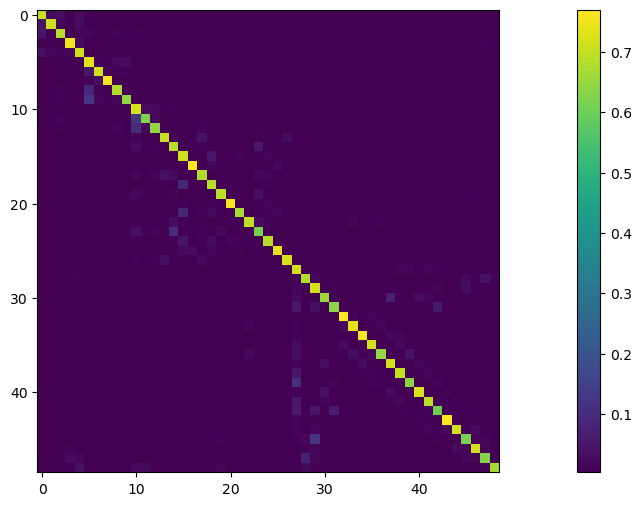

In [38]:
p_ij = p_ij_C(theta)

plt.imshow(p_ij)
plt.colorbar()
plt.show()

## Model setup

In [39]:
from isssm.models import growth_factor_neg_binom_model
from isssm.covariance_matrix import CovarianceMatrix
from isssm.distributions import GaussianInitial
from isssm.distributions import lcssm_to_ssm
import jax.scipy.linalg as jsla

def Omega(theta):
    p_ij = p_ij_C(theta)
    return jnp.exp(theta[2]) * p_ij @ p_ij.T

def Sigma(theta):
    alpha = expit(theta[0], -1, 1)
    return jsla.block_diag(jnp.eye(1), 1 / (1 - alpha ** 2) * Omega(theta))


init_r = jnp.log(observations[0].sum() / lagged_observations[0].sum())
initial_mean = lambda theta: jnp.array([init_r, *jnp.zeros(m - 1)])
initial_covariance = CovarianceMatrix(Sigma)

initial = GaussianInitial(initial_mean, initial_covariance)

model = growth_factor_neg_binom_model(m, p_ij_C, ind_r, initial)
model_ssm = lcssm_to_ssm(model)
    

## Mode Estimation

In [40]:
from isssm.mode_approximation import mode_approximation
from isssm.mode_approximation import IterationParameters
from isssm.sqrt_filter_smoother import sqrt_filter_smoother

iteration_setting = IterationParameters(1e-5, 30)

initial_signal = jnp.log(observations + 1.)
ma_model, ma_observations, ma_result = mode_approximation(
    model, observations, initial_signal, theta, lagged_observations[0], iteration_setting
)
ma_smoothed = sqrt_filter_smoother(ma_model, ma_observations, theta)

In [41]:
ma_result

IterationResult(iterations=Array(30, dtype=int64, weak_type=True), converged=Array(False, dtype=bool))

In [42]:
def plt_compare_growth_factors(signal):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize= (20,10))

    ax1.plot(dates, observations / (lagged_observations + .01),  label = counties)
    ax1.plot(dates, observations.sum(axis = 1) / lagged_observations.sum(axis = 1), color="black")
    ax1.axhline(1, color="grey", linestyle="--")
    ax1.set_title("before")
    ax1.set_ylim(0, 5)

    ax2.set_title("after")
    ax2.plot(dates, jnp.exp(signal), label = counties)
    ax2.plot(dates, observations.sum(axis = 1) / lagged_observations.sum(axis = 1), color="black")
    ax2.axhline(1, color="grey", linestyle="--")
    ax2.set_ylim(0, 5)
    plt.legend(loc="upper right", ncols=2)
    plt.show()

def plt_show_country_log_growth_factor(smoothed_states):
    plt.plot(dates, smoothed_states[:,0])
    plt.title("log growth factor $\\bar r_t$")
    plt.axhline(0, color="grey", linestyle="--")
    plt.show()

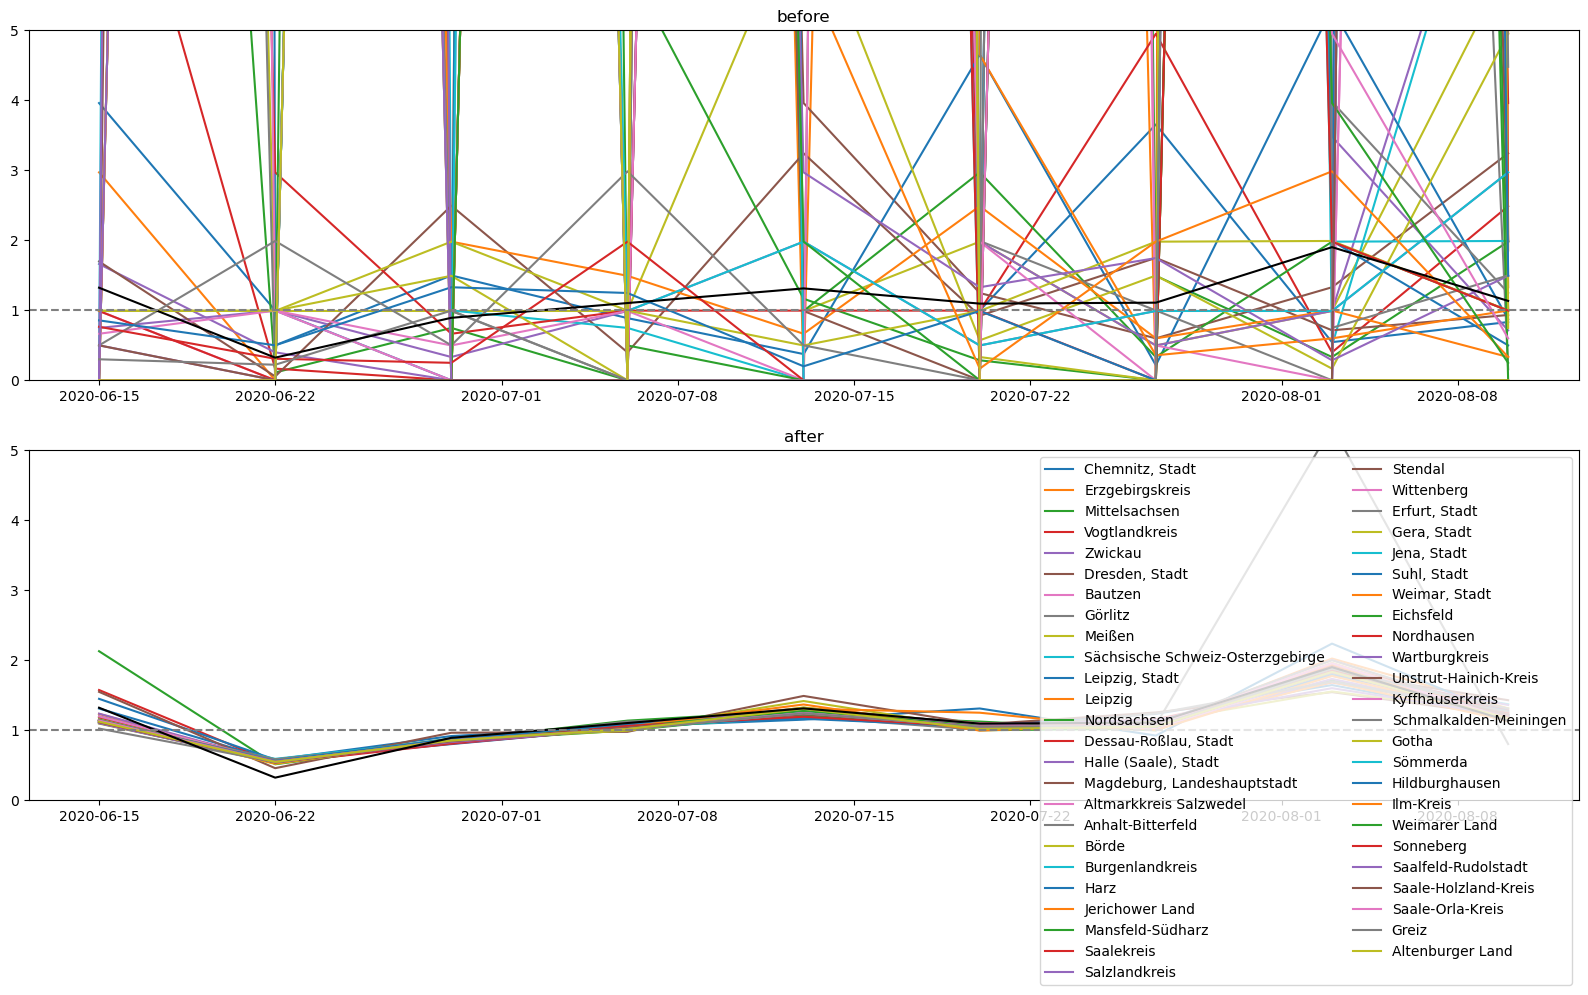

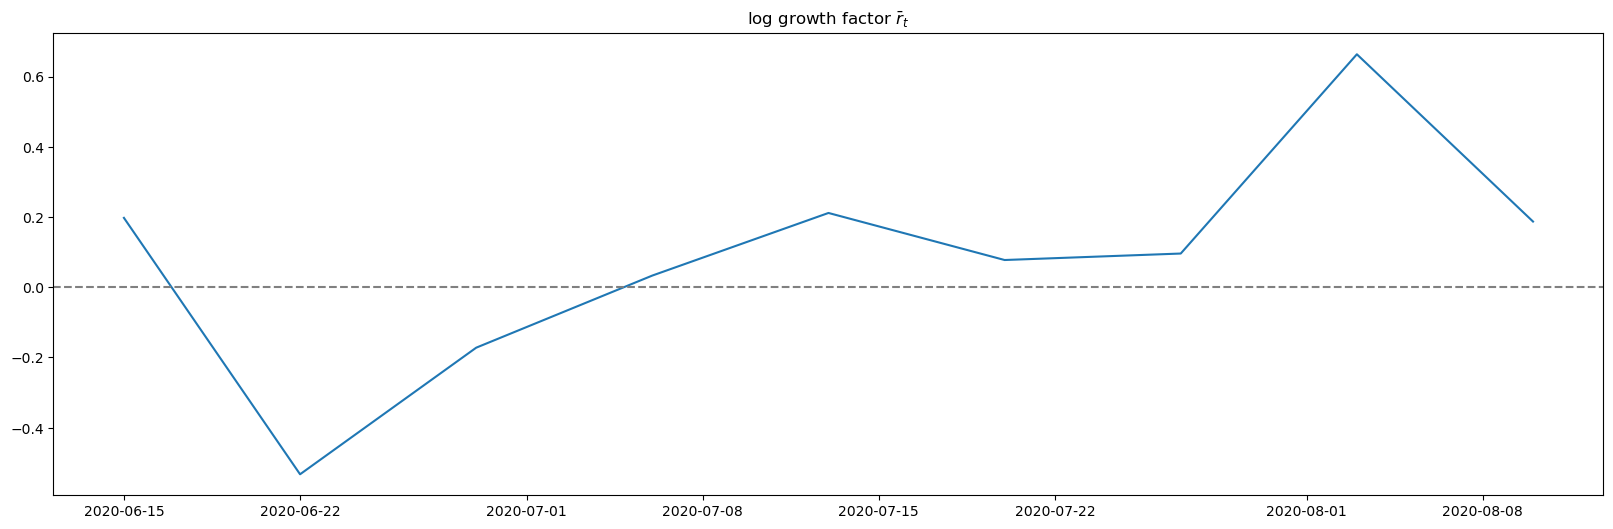

In [43]:
from isssm.sqrt_filter_smoother import sqrt_filter_smoother
plt_compare_growth_factors(ma_observations)
plt_show_country_log_growth_factor(ma_smoothed.X_smooth)

## MEIS model

In [45]:
from isssm.modified_efficient_importance_model import modified_efficient_importance_model, beta_init_from_mode_approximation
from isssm.importance_sampling import gssm_importance_sampling, SimulationParameters
from isssm.importance_sampling import effective_sample_size as ess
import jax.random as jrn

n_sim = 10000
sim = SimulationParameters(n_sim, jrn.PRNGKey(127823))

beta_init = beta_init_from_mode_approximation(ma_model, ma_observations)
meis_model, meis_observations, meis_params, meis_result = modified_efficient_importance_model(model, observations, beta_init, sim, theta, lagged_observations[0], iteration_setting)
meis_smoothed = sqrt_filter_smoother(meis_model, meis_observations, theta)

meis_result

IterationResult(iterations=Array(8, dtype=int64, weak_type=True), converged=Array(True, dtype=bool))

In [46]:
ma_samples, ma_weights = gssm_importance_sampling(
    model_ssm, ma_model, ma_smoothed, sim, observations, ma_observations, lagged_observations[0], theta
)
meis_samples, meis_weights = gssm_importance_sampling(
    model_ssm, meis_model, meis_smoothed, sim, observations, meis_observations, lagged_observations[0], theta
)

print(f"ESS MA= {ess(ma_weights)/n_sim * 100:.2f}%")
print(f"ESS MEIS= {ess(meis_weights)/n_sim * 100:.2f}%")

ESS MA= 0.04%
ESS MEIS= 98.41%


In [47]:
counties

array(['Chemnitz, Stadt', 'Erzgebirgskreis', 'Mittelsachsen',
       'Vogtlandkreis', 'Zwickau', 'Dresden, Stadt', 'Bautzen', 'Görlitz',
       'Meißen', 'Sächsische Schweiz-Osterzgebirge', 'Leipzig, Stadt',
       'Leipzig', 'Nordsachsen', 'Dessau-Roßlau, Stadt',
       'Halle (Saale), Stadt', 'Magdeburg, Landeshauptstadt',
       'Altmarkkreis Salzwedel', 'Anhalt-Bitterfeld', 'Börde',
       'Burgenlandkreis', 'Harz', 'Jerichower Land', 'Mansfeld-Südharz',
       'Saalekreis', 'Salzlandkreis', 'Stendal', 'Wittenberg',
       'Erfurt, Stadt', 'Gera, Stadt', 'Jena, Stadt', 'Suhl, Stadt',
       'Weimar, Stadt', 'Eichsfeld', 'Nordhausen', 'Wartburgkreis',
       'Unstrut-Hainich-Kreis', 'Kyffhäuserkreis',
       'Schmalkalden-Meiningen', 'Gotha', 'Sömmerda', 'Hildburghausen',
       'Ilm-Kreis', 'Weimarer Land', 'Sonneberg', 'Saalfeld-Rudolstadt',
       'Saale-Holzland-Kreis', 'Saale-Orla-Kreis', 'Greiz',
       'Altenburger Land'], dtype=object)

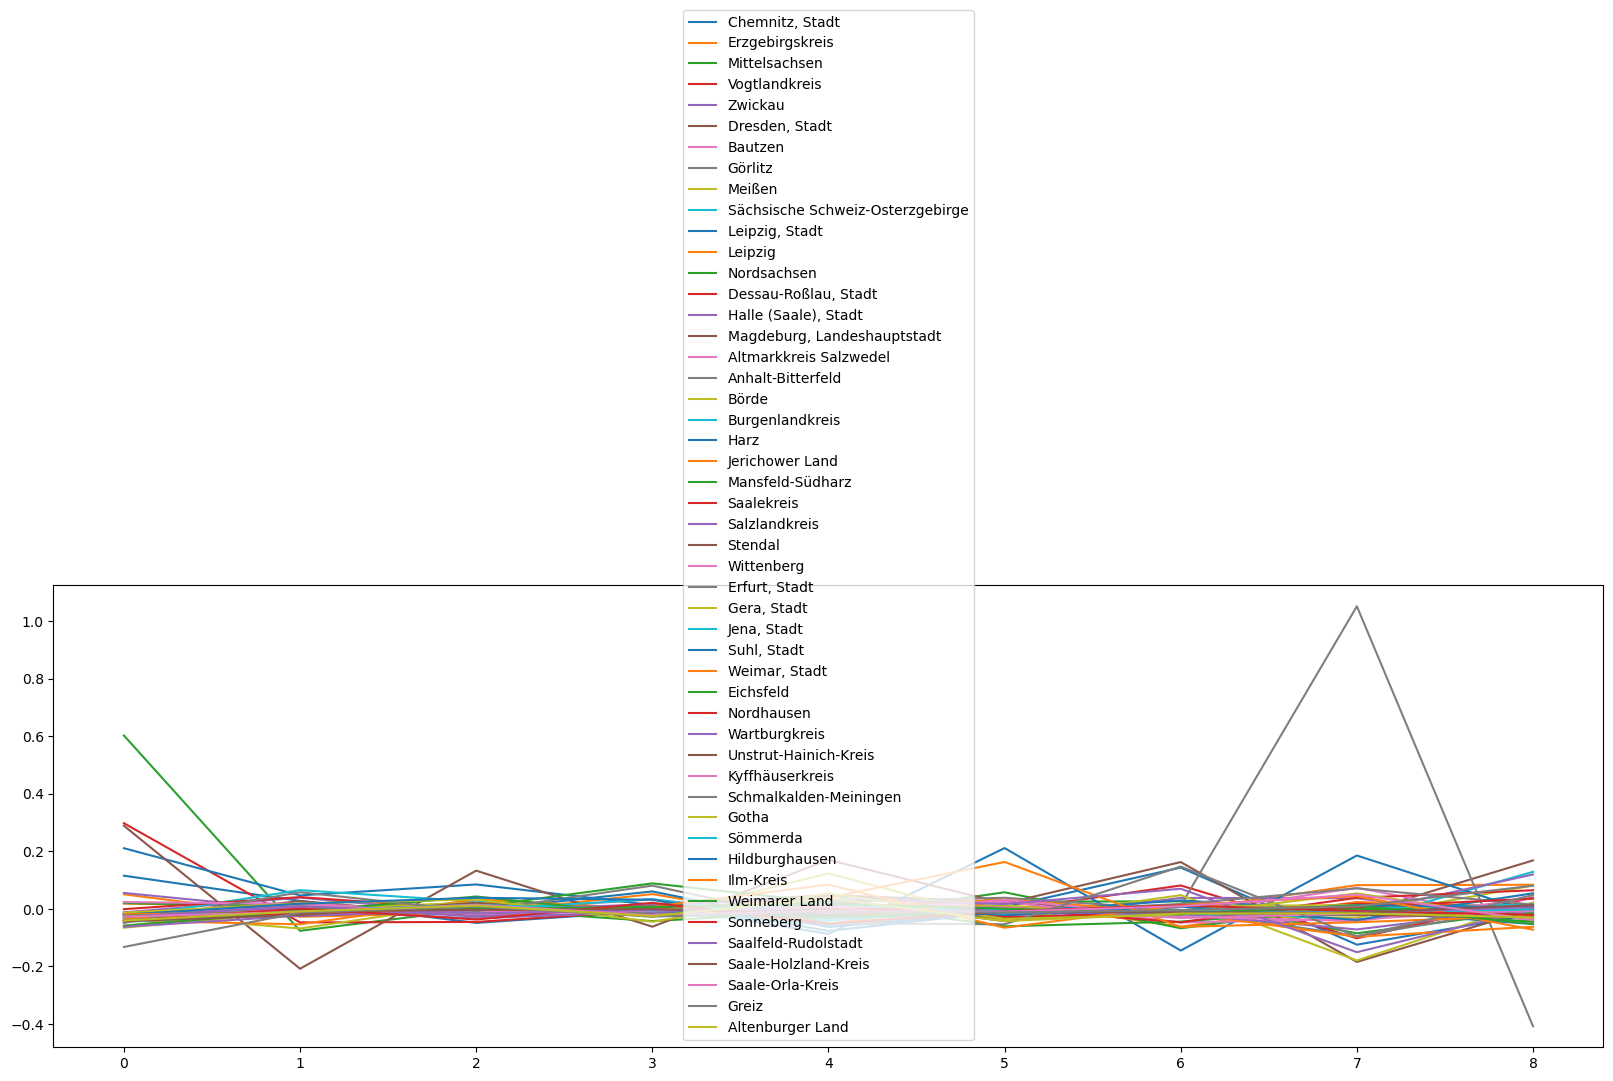

In [48]:
from isssm.importance_sampling import ISWeights
def state_estimates(importance_samples, importance_weights: ISWeights):
    weights_norm = importance_weights.weights_norm
    n_samples, = weights_norm.shape
    return (importance_samples * weights_norm.reshape((n_samples, 1, 1))).sum(axis=0)

plt.plot(state_estimates(meis_samples, meis_weights)[:,1:], label = counties)
plt.legend()
plt.show()

some outliers in states; might investigate later if $t$ errors improve fit (after parameters have been estimated)

# Negative Log Likelihood


In [49]:
from jax import jacfwd, jit
from isssm.importance_sampling import ssm_negloglik
from jax.scipy.optimize import minimize
from isssm.distributions import gssm_to_ssm
from isssm.densities import conditional_density

def nll(theta, meis_observations, meis_model, sim):
    return ssm_negloglik(
        model_ssm,
        observations,
        lagged_observations[0],
        meis_observations,
        meis_model,
        theta,
        sim,
    ).nll


def nll_full(theta):
    iteration_setting = IterationParameters(1e-5, 100)

    initial_signal = jnp.log(observations + 1.0)
    ma_model, ma_observations, ma_result = mode_approximation(
        model,
        observations,
        initial_signal,
        theta,
        lagged_observations[0],
        iteration_setting,
    )
    n_sim = 1000
    sim = SimulationParameters(n_sim, jrn.PRNGKey(127823))

    beta_init = beta_init_from_mode_approximation(ma_model, ma_observations)
    (
        meis_model,
        meis_observations,
        meis_params,
        meis_result,
    ) = modified_efficient_importance_model(
        model,
        observations,
        beta_init,
        sim,
        theta,
        lagged_observations[0],
        iteration_setting,
    )

    sim = SimulationParameters(n_sim, jrn.PRNGKey(6789124))

    return nll(theta, meis_observations, meis_model, sim)
    

# initial value for theta based on Durbin / Koopman CH 11.6.2
def approx_nll(theta):
    
    iteration_setting = IterationParameters(1e-5, 1000)
    ma_model, ma_observations, ma_result = mode_approximation(
        model, observations, initial_signal, theta, lagged_observations[0], iteration_setting
    )
    
    ma_smoothed = sqrt_filter_smoother(ma_model, ma_observations, theta)

    approx_ssm = gssm_to_ssm(ma_model)

    mode_log_p = conditional_density(model_ssm, observations, ma_smoothed.X_smooth, theta, lagged_observations[0])
    mode_log_g = conditional_density(approx_ssm, ma_observations, ma_smoothed.X_smooth, theta, lagged_observations[0])

    return ma_smoothed.filter_result.gnll - mode_log_p + mode_log_g

theta_init = minimize(approx_nll, theta, method="BFGS").x

2023-08-29 07:02:46.707968: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 686.65MiB (rounded to 720000000)requested by op 
2023-08-29 07:02:46.708368: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:497] ****************************************************************************************************
2023-08-29 07:02:46.709638: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2389] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 720000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    52.1KiB
              constant allocation:       616B
        maybe_live_out allocation:   11.80GiB
     preallocated temp allocation:    2.16GiB
                 total allocation:   13.95GiB
Peak buffers:
	Buffer 1:
		Size: 686.65MiB
		XLA Label: copy
		Shape: f64[10

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 720000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    52.1KiB
              constant allocation:       616B
        maybe_live_out allocation:   11.80GiB
     preallocated temp allocation:    2.16GiB
                 total allocation:   13.95GiB
Peak buffers:
	Buffer 1:
		Size: 686.65MiB
		XLA Label: copy
		Shape: f64[1000,9,100,100]
		==========================

	Buffer 2:
		Size: 686.65MiB
		XLA Label: fusion
		Shape: f64[1000,9,100,100]
		==========================

	Buffer 3:
		Size: 686.65MiB
		XLA Label: fusion
		Shape: f64[1000,9,100,100]
		==========================

	Buffer 4:
		Size: 686.65MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/home/sheyder/workspace/10 Professional Primary/11 Research/11.18 ISSSM/src/isssm/mode_approximation.py" source_line=105
		XLA Label: fusion
		Shape: f64[1000,9,100,100]
		==========================

	Buffer 5:
		Size: 686.65MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/home/sheyder/workspace/10 Professional Primary/11 Research/11.18 ISSSM/src/isssm/mode_approximation.py" source_line=105
		XLA Label: fusion
		Shape: f64[1000,9,100,100]
		==========================

	Buffer 6:
		Size: 672.98MiB
		XLA Label: copy
		Shape: f64[1000,9,99,99]
		==========================

	Buffer 7:
		Size: 672.98MiB
		XLA Label: copy
		Shape: f64[1000,9,99,99]
		==========================

	Buffer 8:
		Size: 672.98MiB
		XLA Label: fusion
		Shape: f64[1000,9,99,99]
		==========================

	Buffer 9:
		Size: 672.98MiB
		XLA Label: fusion
		Shape: f64[1000,9,99,99]
		==========================

	Buffer 10:
		Size: 672.98MiB
		XLA Label: fusion
		Shape: f64[1000,9,99,99]
		==========================

	Buffer 11:
		Size: 672.98MiB
		XLA Label: fusion
		Shape: f64[1000,9,99,99]
		==========================

	Buffer 12:
		Size: 672.98MiB
		XLA Label: fusion
		Shape: f64[1000,9,99,99]
		==========================

	Buffer 13:
		Size: 672.98MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/home/sheyder/workspace/10 Professional Primary/11 Research/11.18 ISSSM/src/isssm/mode_approximation.py" source_line=105
		XLA Label: fusion
		Shape: f64[1000,9,99,99]
		==========================

	Buffer 14:
		Size: 305.18MiB
		XLA Label: fusion
		Shape: f64[1000,8,100,50]
		==========================

	Buffer 15:
		Size: 305.18MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/home/sheyder/workspace/10 Professional Primary/11 Research/11.18 ISSSM/src/isssm/mode_approximation.py" source_line=105
		XLA Label: fusion
		Shape: f64[1000,8,50,100]
		==========================



In [ ]:
df_theta(theta_init)

,alpha,s2_rho,s2_spat,q,C,r
0,0.3951017207300602,0.16900219061475721,6.304703371379023e-09,0.3256814441615264,1.8878262472766874,1.4922264305781272


# Model Fitting w/ MLE


In [ ]:
from isssm.modified_efficient_importance_model import MEISResult

def ess_from_theta(theta, meis_result, sim):
    meis_model, meis_observations, _, _= meis_result

    meis_smoothed = sqrt_filter_smoother(meis_model, meis_observations, theta)
    _, meis_weights = gssm_importance_sampling(
        model_ssm, meis_model, meis_smoothed, sim, observations, meis_observations, lagged_observations[0], theta
    )
    return ess(meis_weights)

def nll_diagnostics(theta, meis_observations, meis_model, sim):
    print("--------")
    df = df_theta(theta)
    df["ess"] = [ess_from_theta(theta, MEISResult(meis_model, meis_observations, None, None),sim)]
    df["nll"] = [nll_full(theta)]
    print(df)
    print("--------")

In [ ]:
from scipy.optimize import minimize as scipy_minimize
#min_result = scipy_minimize(nll_full, theta, method="BFGS", options={"maxiter": 10}, callback = print)
theta_opt = theta_init

iteration_setting = IterationParameters(1e-5, 100)
initial_signal = jnp.log(observations + 1.)
ma_model, ma_observations, ma_result = mode_approximation(
    model, observations, initial_signal, theta_opt, lagged_observations[0], iteration_setting
)
n_sim = 100000
sim = SimulationParameters(n_sim, jrn.PRNGKey(127823))

beta_init = beta_init_from_mode_approximation(ma_model, ma_observations)
meis_model, meis_observations, meis_params, meis_result = modified_efficient_importance_model(model, observations, beta_init, sim, theta_opt, lagged_observations[0], iteration_setting)

nll_diagnostics(theta_opt, ma_observations, ma_model, sim)

--------
                alpha               s2_rho                s2_spat  \
0  0.3951017207300602  0.16900219061475721  6.304703371379023e-09   

                    q                   C                   r  \
0  0.3256814441615264  1.8878262472766874  1.4922264305781272   

                  ess                nll  
0  11824.252927385924  410.0728256084666  
--------


In [ ]:
ess_ma = ess_from_theta(theta_opt, MEISResult(ma_model, ma_observations, None, None), sim)
ess_meis = ess_from_theta(theta_opt, MEISResult(meis_model, meis_observations, None, None), sim)

print(f"ESS MA= {ess_ma/n_sim * 100:.2f}%")
print(f"ESS MEIS= {ess_meis/n_sim * 100:.2f}%")
print(f"choosing model with better ess: {['MA', 'MEIS'][int(ess_ma < ess_meis)]}")

model_pred = ma_model if ess_ma < ess_meis else meis_model
observations_pred = ma_observations if ess_ma < ess_meis else meis_observations
smoothed_pred = sqrt_filter_smoother(model_pred, observations_pred, theta_opt)

ESS MA= 11.82%
ESS MEIS= 0.00%
choosing model with better ess: MA


In [ ]:
import os
theta_df = pd.DataFrame(theta_opt.reshape((1, -1)), columns=param_names, index = dates[-1:])
# if ../data/theta_mles.csv does exist, load it
# else create empty dataframe
if os.path.isfile("../data/theta_mles.csv"):
    stored_df = pd.read_csv("../data/theta_mles.csv", index_col=0, parse_dates=True)

    # append theta_df to stored_df
    # ensuring that the index is unique
    df = pd.concat([stored_df, theta_df], axis=0)
else:
    df = theta_df

df = df[~df.index.duplicated(keep='last')]
# sort by index of df
df = df.sort_index()

df.to_csv("../data/theta_mles.csv")

In [ ]:
# apply theta_inv_trafo to rows of df
df_trafo = df.apply(lambda x: pd.Series(theta_trafo(x.to_numpy().astype(float)), param_names), axis=1)
df_trafo

,alpha,s2_rho,s2_spat,q,C,r
date,,,,,,
2020-07-13,0.797465,4.901126e-01,1.845599e-13,0.184512,1.000000e+00,1.148464e+00
2020-07-20,0.434808,5.917936e-01,6.000285e-09,0.178167,1.000055e+00,1.061522e+00
2020-07-27,0.840908,4.685936e-01,8.762457e-16,0.240009,1.000002e+00,8.795411e-01
2020-08-03,-0.062272,2.564172e-01,4.279636e-02,0.381757,1.163880e+00,1.087602e+00
2020-08-10,0.395102,1.690022e-01,6.304703e-09,0.325681,1.887826e+00,1.492226e+00
2020-08-17,0.278118,1.886561e-01,1.528900e-09,0.415246,2.525682e+00,1.706368e+00
2020-08-24,0.016543,4.692576e-03,5.515837e-03,0.559890,2.707938e+00,1.355373e+00
2020-08-31,0.042264,3.064991e-03,5.181397e-03,0.555098,1.982833e+00,1.287299e+00
2020-09-07,0.851861,1.286276e-22,9.779703e-12,0.494071,1.000002e+00,1.351437e+00


# 95% Prediction Intervals 

To perform prediction we have to sample from the conditional distribution of $Y_{n + k} | Y_0, \dots, Y_n$ which we could if we could sample from the conditional distribution of states given $Y_0, \dot Y_n$. 

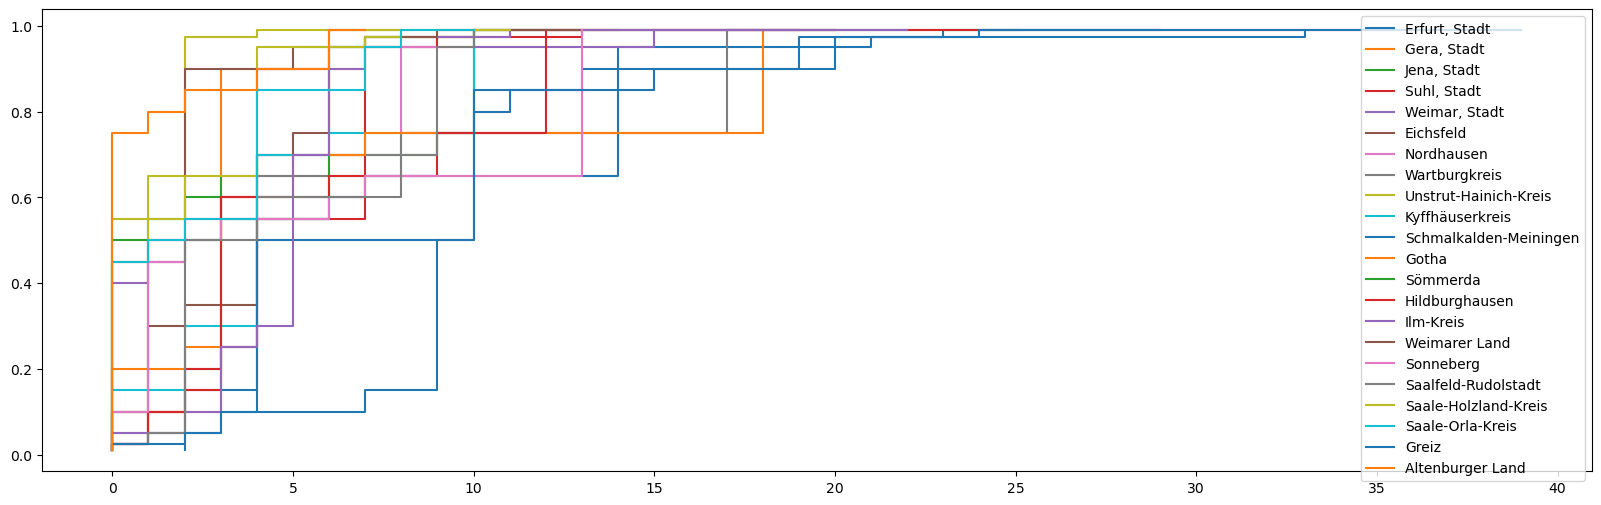

In [ ]:
from isssm.distributions import SSMDistributions, StateParams, ObservationParams
import tensorflow_probability.substrates.jax.distributions as tfd

from jax import vmap
k = 1
prediction_probs = jnp.array([
    0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, .6, .65, .7, .75, .8, .85, .9, .95, .975, .99
])

key = jrn.PRNGKey(1234762314)
key, sk_is, sk_x, sk_y = jrn.split(key, 4)
sim_is = SimulationParameters(100000, sk_is)
samples, weights = gssm_importance_sampling(model_ssm, model_pred, smoothed_pred, sim_is, observations, observations_pred, lagged_observations[0], theta_opt)

Xn_1 = tfd.MultivariateNormalFullCovariance(
    vmap(model.state.A, (None, 0, None))(n + 1, samples[:,-1], theta_opt),
    vmap(model.state.Sigma.cov, (None, 0, None))(n + 1, samples[:,-1], theta_opt)
).sample(seed=sk_x)
mu = jnp.exp(vmap(model.observation.B, (None, 0, None))(n + 1, Xn_1, theta_opt)) * (p_ij_C(theta_opt) @ observations[-1])

r = jnp.exp(theta_opt[ind_r])
Yn_1 = tfd.NegativeBinomial(
    r, probs = mu / (r + mu)
).sample(seed=sk_y)

Y_total = jnp.sum(Yn_1, axis=1)

# sort Y_total in ascending order
# sort weights in same order
# compute cumulative sum of weights

def weighted_quantiles(Y, weights_norm, probs):
    Y_sorted = jnp.sort(Y)
    weights_sorted = weights_norm[jnp.argsort(Y)]
    cumsum = jnp.cumsum(weights_sorted)
    # find indices of cumulative sum closest to prediction_probs
    # take corresponding Y_sorted values
    # with linear interpolation if necessary
    indices = jnp.searchsorted(cumsum, probs)
    indices = jnp.clip(indices, 1, len(Y_sorted) - 1)
    left_indices = indices - 1
    right_indices = indices
    left_cumsum = cumsum[left_indices]
    right_cumsum = cumsum[right_indices]
    left_Y = Y_sorted[left_indices]
    right_Y = Y_sorted[right_indices]
    # linear interpolation
    quantiles = left_Y + (probs - left_cumsum) / (right_cumsum - left_cumsum) * (right_Y - left_Y)
    return quantiles


# stack Yn_1 and Y_total
Y = jnp.hstack((Yn_1, Y_total.reshape((-1,1))))

quantiles = vmap(weighted_quantiles, (1, None, None))(Y, weights.weights_norm, prediction_probs)
for i in jnp.arange(22):
    plt.step(quantiles[i], prediction_probs, label = counties[i])
plt.legend() 
plt.show()

In [ ]:
pred_df = pd.DataFrame(quantiles.T, index = prediction_probs, columns = [*counties, "total"])

# add index name to pred_df
pred_df.index.name = 'quantile'
# move index of pred_df into column
pred_df = pred_df.reset_index()
# add data date column equal to last date of observations
pred_df['data_date'] = dates[-1]
# add prediction date column equal to first date of predictions, which is one week after data date
pred_df['pred_date'] = dates[-1] + pd.Timedelta(days=7)
# arrange columns so that quantile, data_date and pred_date are first
pred_df = pred_df[['quantile', 'data_date', 'pred_date', *pred_df.columns[1:-2]]]
# pivot the counties and total into rows
pred_df = pred_df.melt(id_vars=['quantile', 'data_date', 'pred_date'], var_name='region', value_name='value')
# save as csv, format dates to iso format
pred_df.to_csv(f"../data/prediction_intervals/{dates[-1].strftime('%Y-%m-%d')}.csv", index=False)

In [ ]:
# find all prediction interval dates
# from the file names present in ../data/prediction_intervals
import os
all_prediction_dates = [
    f.split('.')[0] for f in os.listdir('../data/prediction_intervals')
]

# read all prediction intervals from ../data/prediction_intervals
# the files have to be named as the date of the last observation
all_pred_df = pd.concat([  
    pd.read_csv(f"../data/prediction_intervals/{date}.csv", parse_dates=['data_date', 'pred_date'])
    for date in all_prediction_dates
])

# sort all_pred_df by data_date, pred_date and quantile
all_pred_df = all_pred_df.sort_values(['data_date', 'pred_date', 'quantile'])
all_pred_df

,quantile,data_date,pred_date,region,value
0,0.01,2020-07-13,2020-07-20,"Erfurt, Stadt",0.0
23,0.01,2020-07-13,2020-07-20,"Gera, Stadt",0.0
46,0.01,2020-07-13,2020-07-20,"Jena, Stadt",0.0
69,0.01,2020-07-13,2020-07-20,"Suhl, Stadt",0.0
92,0.01,2020-07-13,2020-07-20,"Weimar, Stadt",0.0
...,...,...,...,...,...
436,0.99,2020-11-30,2020-12-07,Saale-Holzland-Kreis,NaN
459,0.99,2020-11-30,2020-12-07,Saale-Orla-Kreis,NaN
482,0.99,2020-11-30,2020-12-07,Greiz,NaN
505,0.99,2020-11-30,2020-12-07,Altenburger Land,NaN


In [ ]:
rki_full = rki.pivot(index='date', columns='ags', values='cases')
# replace columns in rki_full with the counties
rki_full.columns = counties

# get total number of cases per week by summing all counties
rki_full['total'] = rki_full.sum(axis=1)

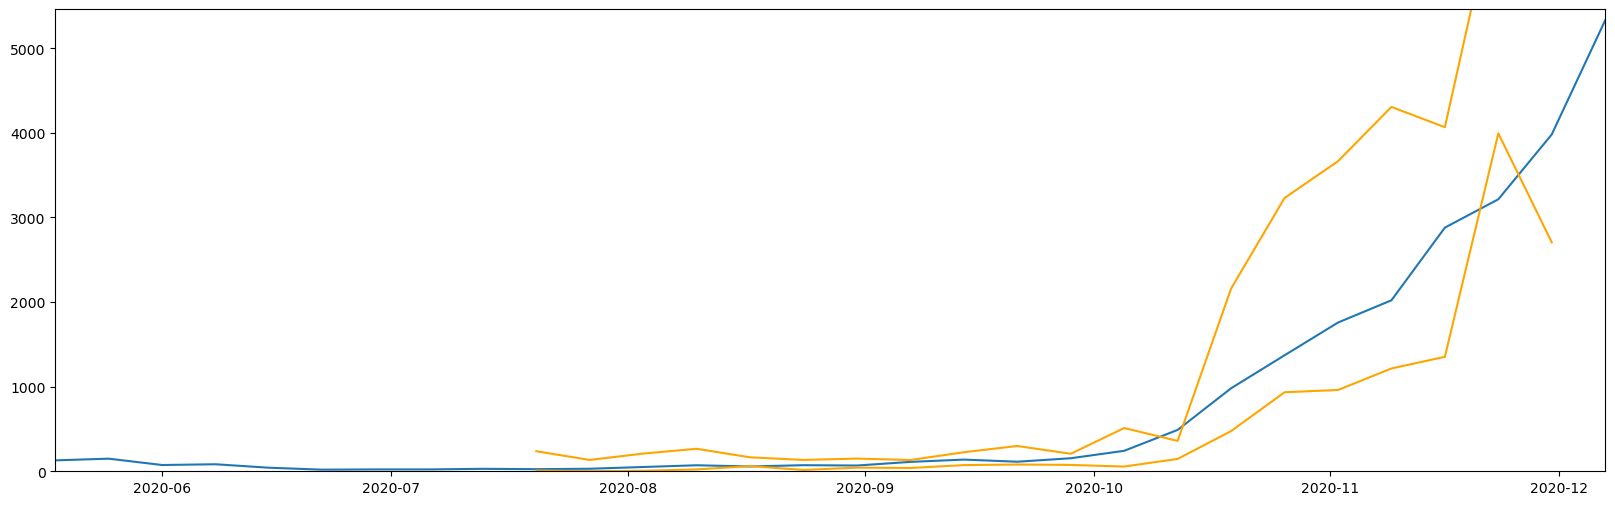

In [ ]:
# plot date index of rki_full against total number of cases
# restrict to 8 weeks before first date in all_pred_df and last date in all_pred_df
plt.plot(rki_full.index, rki_full['total'])
plt.xlim(all_pred_df['data_date'].min() - pd.Timedelta(days=56), all_pred_df['data_date'].max() + pd.Timedelta(days=7))
# restrict ylim to maximal number of cases in all_pred_df for .95 quantile
plt.ylim(0, all_pred_df[all_pred_df['quantile'] == .95]['value'].max())

# plot precdition intervals from all_pred_df
# use only the total column and the .025 and .975 quantiles
plt.plot(all_pred_df[all_pred_df['region'] == 'total'].pivot(index='pred_date', columns='quantile', values='value')[[.025, .975]], color = "orange")
plt.show()
#all_pred_df[all_pred_df['region'] == 'total'].pivot(index='pred_date', columns='quantile', values='value')
